<a href="https://colab.research.google.com/github/MatiasH2804/Proyecto-Parte-III-Henqu-n/blob/main/ProyectoParteIII%2BHenqu%C3%ADn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANÁLISIS EXPLORATORIO Y MODELAJE DE PRECIOS DE AUTOMÓVILES EN ARGENTINA

### Entregable Final
**Curso de Data Science I — CoderHouse**  
**Matías Henquín**  
**Fecha de entrega: 24/07/2025**

Este trabajo aplica técnicas de selección de características, entrenamiento de modelos de regresión, evaluación de métricas y visualización para explorar y predecir precios de autos publicados en Argentina.



# **Introducción y Contexto**

En este notebook desarrollamos el trabajo final de éste curso. El objetivo general es aplicar herramientas de análisis exploratorio, reducción de dimensionalidad, y evaluación de métricas, para arribar a conclusiones sobre un dataset real de autos de nuestra nación.

El dataset que utilizamos contiene información de autos publicados para la venta en Argentina, en el año 2023; incluyendo variables como: marca, modelo, año, tipo de cuerpo, tipo de combustible, cantidad de kilómetros, entre otros.

La particularidad del conjunto de datos es que fue previamente limpiado y ajustado (por nosotros) para reflejar precios más realistas en dólares, creando una nueva columna llamada **Precio Dolarizado**. A partir de esta base, nos enfocamos en analizar algúnas marcas del mercado nacional, analizando precios entre autos nuevos y usados, cantidad de autos por marca, etc.

## **Objetivos específicos de esta sección**

Realizar una exploración visual de los datos.  
Analizar relaciones entre variables clave (precio, marca, estado, tipo de caja).  
Establecer hipótesis para luego validar con modelos.  

A lo largo del Colab, cada sección estará documentada, comentando los criterios usados y justificando cada decisión, de modo quese pueda entender bien el camino tomado en el análisis.



#**1. Importación de librerías**

### En esta celda agrupamos todas las librerías necesarias para el proyecto.
### Esto nos permite mantener el código organizado y evitar errores futuros relacionados con funciones no definidas.

#####pandas: para manejar y explorar los datos en formato de tabla (DataFrames).
#####numpy: para realizar operaciones numéricas y manejar arrays.
#####matplotlib.pyplot: para crear gráficos clásicos (líneas, barras, etc.).
#####seaborn: para hacer gráficos estadísticos más visuales y estilizados.
#####seaborn.objects: para gráficos más flexibles y modernos con el nuevo sistema de objetos.
#####train_test_split (de sklearn): para separar los datos en entrenamiento y prueba.
#####LinearRegression (de sklearn): para crear un modelo de regresión lineal.
#####métricas de sklearn: para evaluar el rendimiento del modelo (MAE, MSE y R²).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#**2. Importación del DF del Drive**
Ahora, lo que hacemos, es buscar en el drive el dataset con el que vamos a trabajar


In [ ]:
from google.colab import auth
auth.authenticate_user()
import gspread
from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)
spreadsheet = gc.open("Autos De Argentina")
worksheet = spreadsheet.sheet1
df = pd.DataFrame(worksheet.get_all_records())
df.head()

,Marca,Modelo,Año,Color,Combustible,Puertas,Caja de cambio,Motor,Tipo de cuerpo,kilometros de uso,Moneda,Precio
0,Toyota,Corolla Cross,2022,Plateado,Nafta,50,Automática,,SUV,500,dólares,7.5
1,Jeep,Compass,2022,Blanco,Nafta,50,Automática,2.4,SUV,500,dólares,8.6
2,Jeep,Compass,2022,Gris oscuro,Nafta,50,Automática,2.4,SUV,500,dólares,8.6
3,Citroën,C4 Cactus,2022,Gris oscuro,Nafta,50,Automática,,SUV,550,dólares,7.9
4,Toyota,Corolla,2019,Gris,Nafta,40,Manual,1.8,Sedán,9000,pesos,5000000.0


#**3. "EDA": Analisis exploratorio y de limpieza de datos**

### En las siguientes secciones realizaré una serie de operaciones tendientes a corregir errores comúnes que aparecen en las bases de datos.
De ésta manera se intenta normalizar la base de datos antes de trabajar con ella.


In [ ]:
# Detectar datos faltantes
print(df.isnull().sum())
# Convertir a numérico solo la columna que corresponde
df['kilometros de uso'] = pd.to_numeric(df['kilometros de uso'], errors='coerce')
# Eliminar filas con datos faltantes
df = df.dropna()
# Verificar nuevamente
print(df.isnull().sum())
# Vista previa del DataFrame
df.head()

Marca                0
Modelo               0
Año                  0
Color                0
Combustible          0
Puertas              0
Caja de cambio       0
Motor                0
Tipo de cuerpo       0
kilometros de uso    0
Moneda               0
Precio               0
dtype: int64
Marca                0
Modelo               0
Año                  0
Color                0
Combustible          0
Puertas              0
Caja de cambio       0
Motor                0
Tipo de cuerpo       0
kilometros de uso    0
Moneda               0
Precio               0
dtype: int64


,Marca,Modelo,Año,Color,Combustible,Puertas,Caja de cambio,Motor,Tipo de cuerpo,kilometros de uso,Moneda,Precio
0,Toyota,Corolla Cross,2022,Plateado,Nafta,50,Automática,,SUV,500,dólares,7.5
1,Jeep,Compass,2022,Blanco,Nafta,50,Automática,2.4,SUV,500,dólares,8.6
2,Jeep,Compass,2022,Gris oscuro,Nafta,50,Automática,2.4,SUV,500,dólares,8.6
3,Citroën,C4 Cactus,2022,Gris oscuro,Nafta,50,Automática,,SUV,550,dólares,7.9
4,Toyota,Corolla,2019,Gris,Nafta,40,Manual,1.8,Sedán,9000,pesos,5000000.0


En este paso se crea una columna unificada en dólares reales, llamada "Precio Dolarizado". La base tenía precios tanto en pesos como en dólares, así que se convierten todos a una misma unidad, actualizados a dólar 2023. Luego se eliminan las columnas originales para evitar confusión y se muestra un ejemplo de los datos procesados.

In [ ]:
# Volvemos a cargar el DataFrame desde la hoja de cálculo (por si fue modificado antes)
df = pd.DataFrame(worksheet.get_all_records())
# Asegurarse que los nombres de columnas estén en minúsculas y sin espacios
df.columns = df.columns.str.strip().str.lower()
# Creamos la columna final con precios dolarizados
df['Precio Dolarizado'] = df.apply(lambda fila: float(fila['precio']) / 1000 if fila['moneda'].strip().lower() == 'pesos'else float(fila['precio']) * 1000, axis=1)
# Eliminamos las columnas originales 'precio' y 'moneda'
df.drop(columns=['precio', 'moneda'], inplace=True)
# Mostramos el resultado
df.head()


,marca,modelo,año,color,combustible,puertas,caja de cambio,motor,tipo de cuerpo,kilometros de uso,Precio Dolarizado
0,Toyota,Corolla Cross,2022,Plateado,Nafta,50,Automática,,SUV,500,7500.0
1,Jeep,Compass,2022,Blanco,Nafta,50,Automática,2.4,SUV,500,8600.0
2,Jeep,Compass,2022,Gris oscuro,Nafta,50,Automática,2.4,SUV,500,8600.0
3,Citroën,C4 Cactus,2022,Gris oscuro,Nafta,50,Automática,,SUV,550,7900.0
4,Toyota,Corolla,2019,Gris,Nafta,40,Manual,1.8,Sedán,9000,5000.0


Algunos registros tienen cantidades absurdas como 10, 20 o 30 puertas. Se convierten esos valores por su correspondiente sin ceros finales (por ejemplo, 10 pasa a 1), asumiendo que son errores de carga. También se fuerza el tipo numérico para evitar problemas posteriores en el análisis.

In [ ]:
# Convertir 'puertas' a número por si hay strings
df['puertas'] = pd.to_numeric(df['puertas'], errors='coerce')
# Reemplazar valores tipo 10, 20, 30, ... por su correspondiente sin el cero
df['puertas'] = df['puertas'].apply(lambda x: x // 10 if x in [10, 20, 30, 40, 50] else x)
# Verificar resultado
df['puertas'].value_counts()
df.head()

,marca,modelo,año,color,combustible,puertas,caja de cambio,motor,tipo de cuerpo,kilometros de uso,Precio Dolarizado
0,Toyota,Corolla Cross,2022,Plateado,Nafta,5,Automática,,SUV,500,7500.0
1,Jeep,Compass,2022,Blanco,Nafta,5,Automática,2.4,SUV,500,8600.0
2,Jeep,Compass,2022,Gris oscuro,Nafta,5,Automática,2.4,SUV,500,8600.0
3,Citroën,C4 Cactus,2022,Gris oscuro,Nafta,5,Automática,,SUV,550,7900.0
4,Toyota,Corolla,2019,Gris,Nafta,4,Manual,1.8,Sedán,9000,5000.0


Las columnas de tipo categórico (como color, tipo de combustible, motor, etc.) se limpian reemplazando espacios vacíos por NaN y luego se rellenan con la etiqueta **"Sin_Dato"**, para que no afecten en los modelos ni en los gráficos posteriores.

In [ ]:
# Lista de columnas categóricas a completar
columnas_a_rellenar = ['color', 'combustible', 'caja de cambio', 'motor', 'tipo de cuerpo']
for col in columnas_a_rellenar:
    df[col] = df[col].replace(r'^\s*$', pd.NA, regex=True)
    # Reemplazar NA con 'Sin_Dato'
    df[col] = df[col].fillna('Sin_Dato')
df.head()

,marca,modelo,año,color,combustible,puertas,caja de cambio,motor,tipo de cuerpo,kilometros de uso,Precio Dolarizado
0,Toyota,Corolla Cross,2022,Plateado,Nafta,5,Automática,Sin_Dato,SUV,500,7500.0
1,Jeep,Compass,2022,Blanco,Nafta,5,Automática,2.4,SUV,500,8600.0
2,Jeep,Compass,2022,Gris oscuro,Nafta,5,Automática,2.4,SUV,500,8600.0
3,Citroën,C4 Cactus,2022,Gris oscuro,Nafta,5,Automática,Sin_Dato,SUV,550,7900.0
4,Toyota,Corolla,2019,Gris,Nafta,4,Manual,1.8,Sedán,9000,5000.0


#**4. Análisis gráfico de las variables**

A continuación, se presentan distintos gráficos que nos permitirán identificar patrones, detectar valores atípicos y comprender mejor la estructura del dataset.

## 4.1 Distribución de autos por tipo de carrocería

Este primer gráfico nos muestra la **cantidad de autos disponibles según el tipo de carrocería**. Esta información es útil para entender qué formatos predominan en el dataset, y también para observar si hay algún tipo subrepresentado que pueda afectar el análisis posterior (por ejemplo, SUV, sedán, hatchback, etc.).


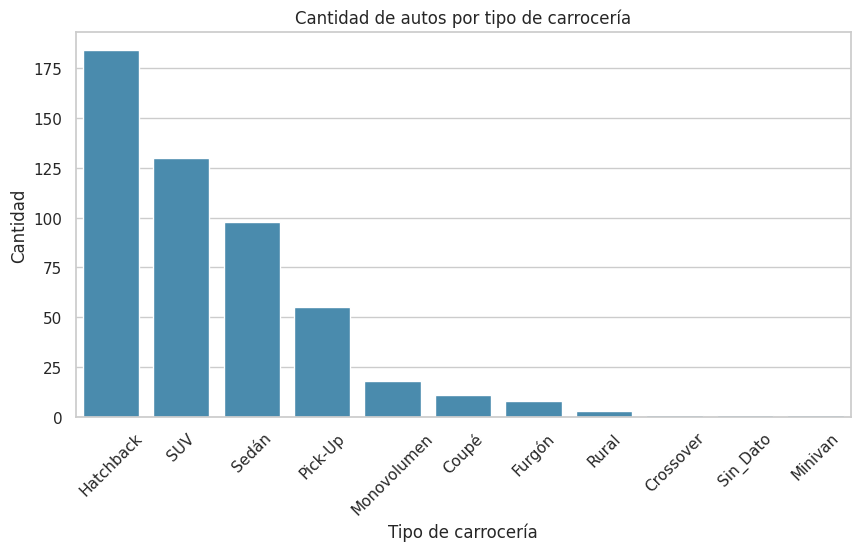

In [ ]:
sns.set(style="whitegrid", palette=["#3990BE"])
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='tipo de cuerpo', order=df['tipo de cuerpo'].value_counts().index, color="#3990BE")
plt.title("Cantidad de autos por tipo de carrocería")
plt.xticks(rotation=45)
plt.xlabel("Tipo de carrocería")
plt.ylabel("Cantidad")
plt.show()

**Conclusión**  
Podemos observar que ciertos tipos de carrocería (como los SUV y los sedanes y los hatchback) tienen una representación mucho mayor que otros. Esta información será útil para futuras segmentaciones o para evaluar si el tipo de carrocería influye en el precio de los vehículos.


## 4.2  Distribución de precios por marca (Top 10)

Ahora nos interesa observar cómo se distribuyen los precios dentro de las marcas más representadas del dataset. Para esto, filtraremos las 10 marcas con mayor cantidad de registros y analizaremos visualmente su comportamiento de precios usando un gráfico de violín, que además de mostrar el rango, permite visualizar la densidad y simetría de los valores.


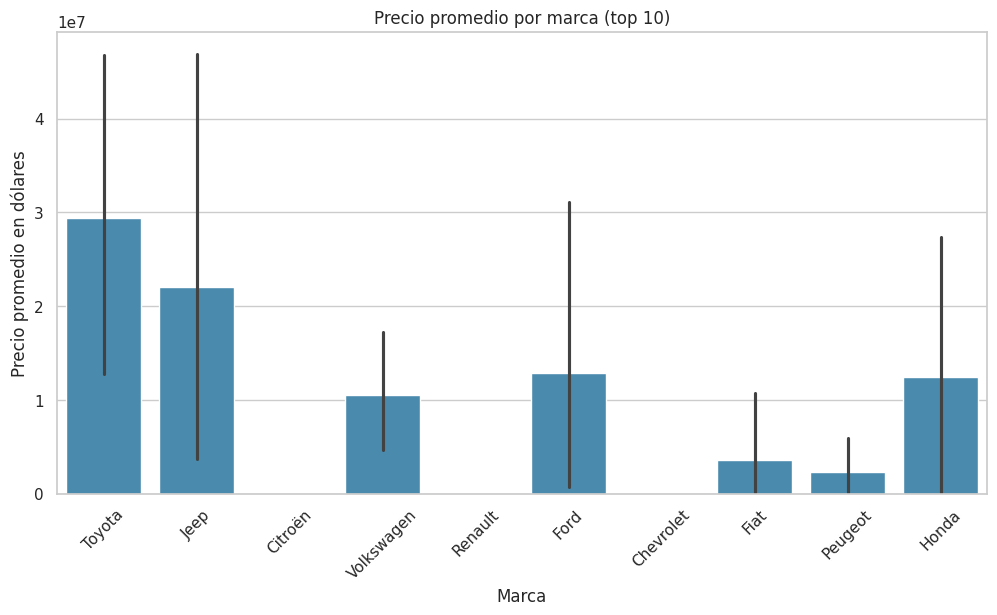

In [ ]:
# Promedio de precios por marca (top 10)
plt.figure(figsize=(12,6))
top_marcas = df['marca'].value_counts().head(10).index
sns.barplot(data=df[df['marca'].isin(top_marcas)], x='marca', y='Precio Dolarizado', estimator='mean')
plt.title("Precio promedio por marca (top 10)")
plt.ylabel("Precio promedio en dólares")
plt.xlabel("Marca")
plt.xticks(rotation=45)
plt.show()
# Modificar grafico a violin

**Conclusión**

Observamos que marcas como **Toyota** y **Jeep** se destacan por tener los precios promedios más altos entre las más vendidas, mientras que marcas como **Fiat** y **Peugeot** presentan precios considerablemente más bajos. Esta información resulta útil para segmentar el análisis en función de gamas o posicionamiento de mercado.


## 4.3 Distribución general de precios en USD

Antes de analizar precios por categorías específicas, es útil observar cómo están distribuidos en general los valores del dataset. Esto nos permite detectar comportamientos globales, como la existencia de valores extremos, la concentración de precios o la forma general de la distribución.

Para ello, utilizamos un **histograma con curva de densidad** que nos muestra cuántos autos hay para cada rango de precios.


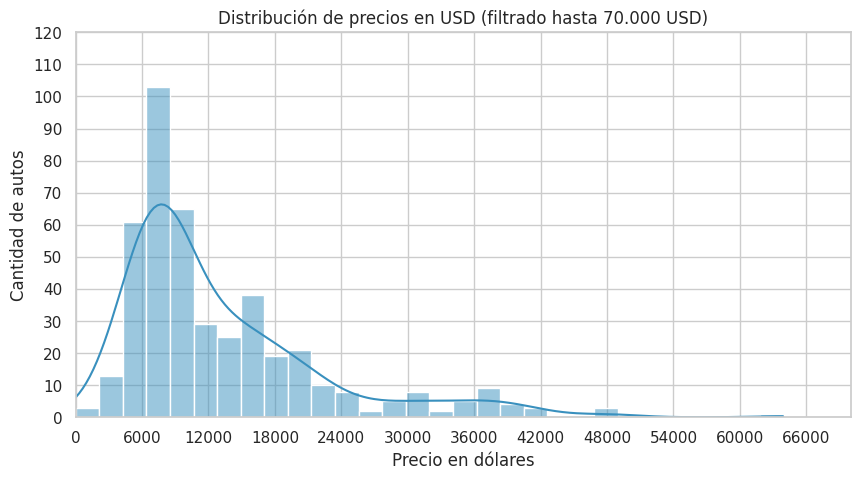

In [ ]:
# Gráfico de distribución general de precios (sin outliers extremos)
plt.figure(figsize=(10, 5))
# Filtrar precios razonables (hasta 70.000 USD)
df_filtrado = df[df['Precio Dolarizado'] <= 70000]
# Crear histograma + curva KDE
sns.histplot(df_filtrado['Precio Dolarizado'], bins=30, kde=True, color="#3990BE")
# Personalizar ejes
plt.title("Distribución de precios en USD (filtrado hasta 70.000 USD)")
plt.xlabel("Precio en dólares")
plt.ylabel("Cantidad de autos")
# Eje Y: ticks de a 10
plt.yticks(np.arange(0, 121, 10))
# Eje X: ticks de a 2.000 USD
plt.xticks(np.arange(0, 70001, 6000))
# Limitar eje X
plt.xlim(0, 70000)
plt.show()

**Conclusión**
He decidido analizar precios menores a 70mil dólares, debido a que hay valores que son irracionales

"# Filtrar precios razonables (hasta 70.000 USD)
df_filtrado = df[df['Precio Dolarizado'] <= 70000]"

La mayoría de los autos disponibles en la base se concentran entre los 6.000 y 15.000 dólares, lo que refleja un mercado con fuerte presencia de vehículos económicos. La curva está sesgada hacia la derecha, lo que indica que hay unidades con precios considerablemente más altos. Estos valores extremos, aunque pocos, podrían distorsionar futuros análisis estadísticos o modelos predictivos, por lo que conviene evaluarlos aparte o aplicar técnicas de normalización si es necesario.

## 4.4 Análisis del tipo de combustible

En esta sección vamos a visualizar cuántos autos utilizan cada tipo de combustible. Esta información es clave para entender la composición energética del parque automotor dentro de nuestro dataset.

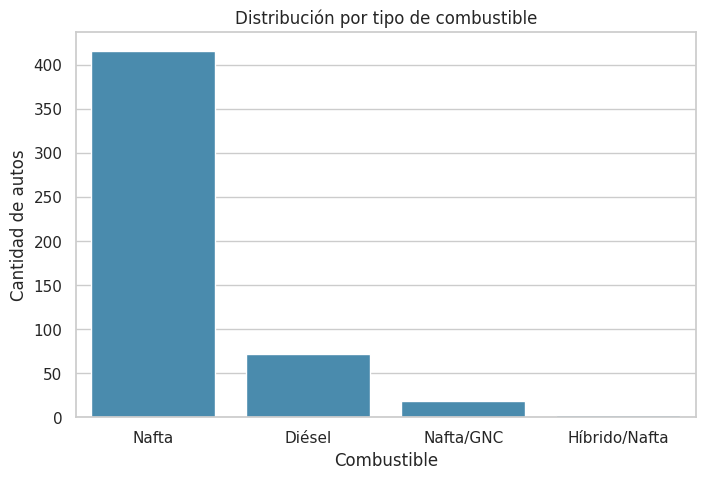

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='combustible', order=df['combustible'].value_counts().index)
plt.title("Distribución por tipo de combustible")
plt.xlabel("Combustible")
plt.ylabel("Cantidad de autos")
plt.show()

**Conclusión**

Se observa una clara predominancia de autos que funcionan con **Nafta**, seguidos a gran distancia por los que usan **Diésel** o combinaciones como **Nafta/GNC**. Los autos **híbridos** son prácticamente inexistentes en esta muestra. Esto sugiere que la mayoría de los vehículos analizados aún se encuentran lejos de tecnologías más modernas o sustentables.

## 4.5 Relación entre tipo de carrocería y caja de cambios

En este apartado se busca identificar cómo varía la distribución del tipo de transmisión (manual, automática) según el tipo de carrocería del vehículo. Este análisis permite detectar patrones de preferencia o disponibilidad de transmisiones asociadas a ciertos estilos de vehículos.


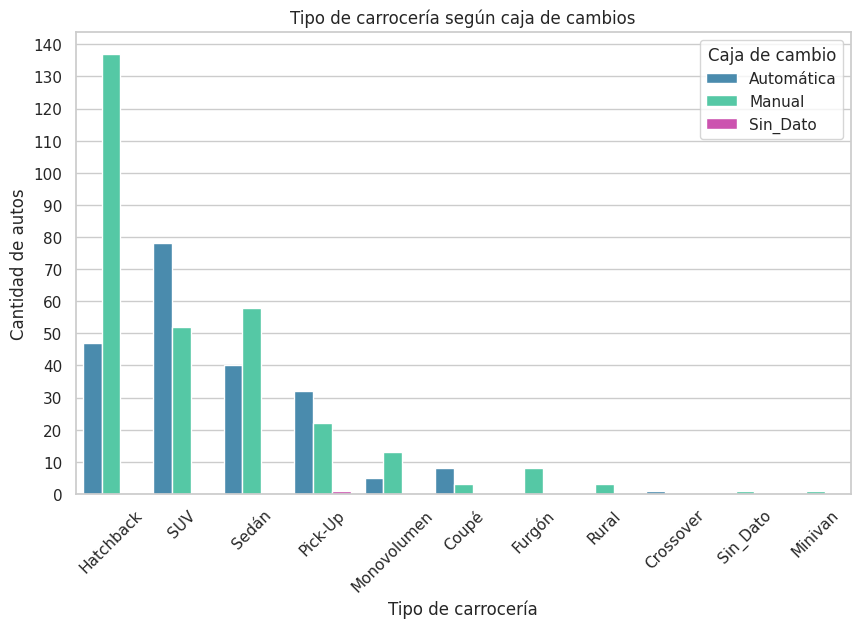

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(
    data=df,
    x='tipo de cuerpo',
    hue='caja de cambio',
    order=df['tipo de cuerpo'].value_counts().index,
    palette=["#3990BE", "#42DBAD", "#E03FB9"]
)
plt.title("Tipo de carrocería según caja de cambios")
plt.xlabel("Tipo de carrocería")
plt.ylabel("Cantidad de autos")
plt.xticks(rotation=45)
plt.yticks(np.arange(0, 141, 10))  # Hasta 140 de a 10
plt.legend(title='Caja de cambio')
plt.show()


**Conclusión**

Se observa una **clara preferencia por transmisiones manuales** en la mayoría de las carrocerías, en especial en los **Hatchbacks y Sedanes**. Por otro lado, las **SUVs y Pick-Ups** presentan una proporción más equilibrada entre manuales y automáticas. Las carrocerías menos frecuentes tienen menor representatividad pero también tienden a ser mayoritariamente manuales. El análisis refuerza la hipótesis de que el tipo de caja está asociado a la categoría del vehículo y su orientación de uso (urbano, familiar o utilitario).


## 4.6 Distribución por cantidad de puertas
A continuación analizamos cómo se distribuyen los vehículos en la base de datos según la cantidad de puertas que poseen. Esta variable puede relacionarse con el tipo de vehículo (por ejemplo, sedanes, SUVs, coupés, etc.), y nos da una idea general de las configuraciones más comunes.

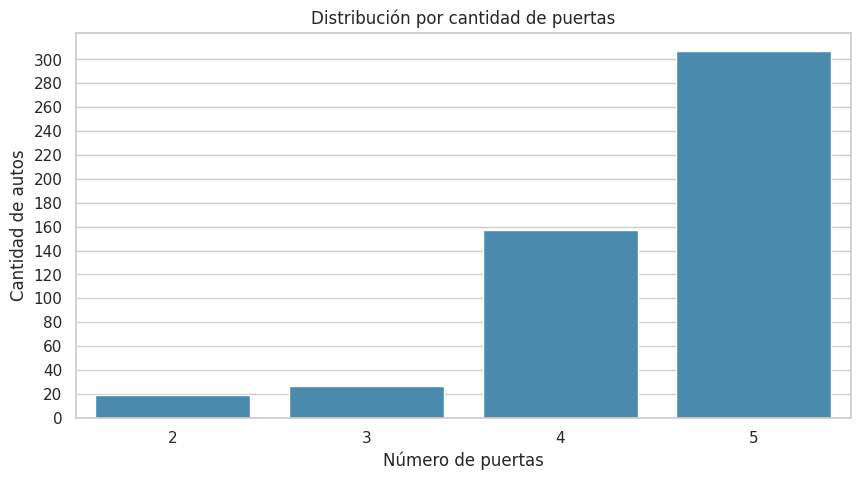

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='puertas', order=sorted(df['puertas'].unique()), color="#3990BE")
plt.title("Distribución por cantidad de puertas")
plt.xlabel("Número de puertas")
plt.ylabel("Cantidad de autos")
plt.yticks(np.arange(0, 301, 20))
plt.show()

**Conclusión**

Se observa que la mayoría de los vehículos tienen 4 o 5 puertas, lo cual es esperable dado que estos formatos son los más comunes en autos familiares, utilitarios y SUV. Las configuraciones con 2 puertas son mucho menos frecuentes, posiblemente asociadas a modelos coupé o deportivos. Esta variable podría ser útil para identificar segmentos de vehículos según su diseño o funcionalidad.

## 4.7 Relación entre kilometraje y precio
En esta sección vamos a explorar si existe una relación significativa entre los kilómetros recorridos por un vehículo y su precio en dólares. La lógica sugiere que, a mayor uso (mayor kilometraje), el precio debería tender a ser más bajo. Sin embargo, es importante visualizar si esto realmente se manifiesta en el dataset disponible, y si hay patrones u outliers que puedan sesgar los resultados.



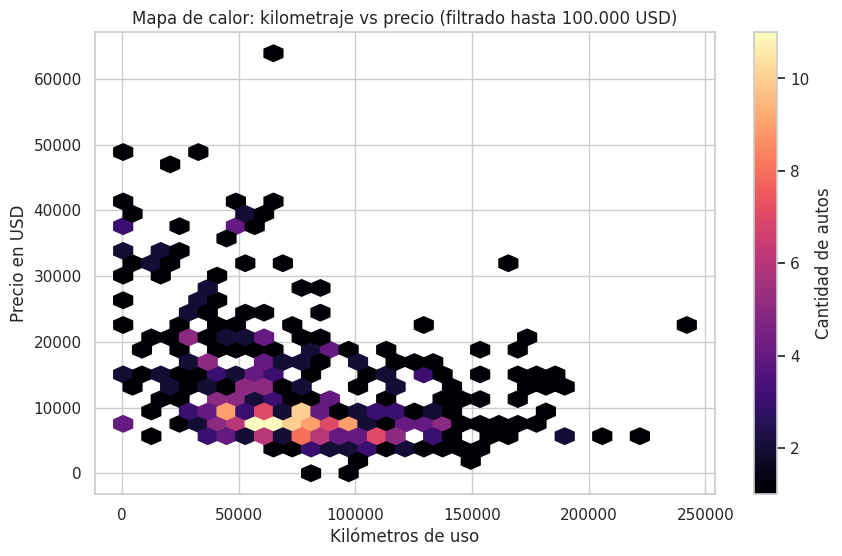

In [ ]:
plt.figure(figsize=(10,6))
df_filtrado = df[df['Precio Dolarizado'] <= 100000]  # Límite superior razonable
plt.hexbin(df_filtrado['kilometros de uso'],df_filtrado['Precio Dolarizado'],gridsize=30,cmap="magma",mincnt=1)
plt.colorbar(label='Cantidad de autos')
plt.title("Mapa de calor: kilometraje vs precio (filtrado hasta 100.000 USD)")
plt.xlabel("Kilómetros de uso")
plt.ylabel("Precio en USD")
plt.grid(True)
plt.show()

**Conclusión**

Se confirma una tendencia esperada: los vehículos con menor kilometraje concentran los precios más altos, mientras que los de mayor uso tienden a ubicarse en rangos más bajos de precio.

Además, el mapa de calor destaca zonas de alta densidad de autos económicos con uso moderado, lo cual es información clave para entrenar modelos de predicción más precisos, eliminar outliers y ajustar rangos realistas en los modelos de regresión o clasificación.


## 4.8 Combustible y precio
La relación entre el tipo de combustible y el precio de los autos puede revelar patrones importantes para la segmentación del mercado y la identificación de productos premium o económicos. Este análisis busca explorar cómo varía el precio de los autos según el combustible que utilizan, considerando además la distribución y dispersión de estos valores para cada categoría.

/tmp/ipython-input-14-2993957016.py:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = df_heat.pivot_table(index='combustible',columns='Precio Bin',aggfunc='size',fill_value=0)


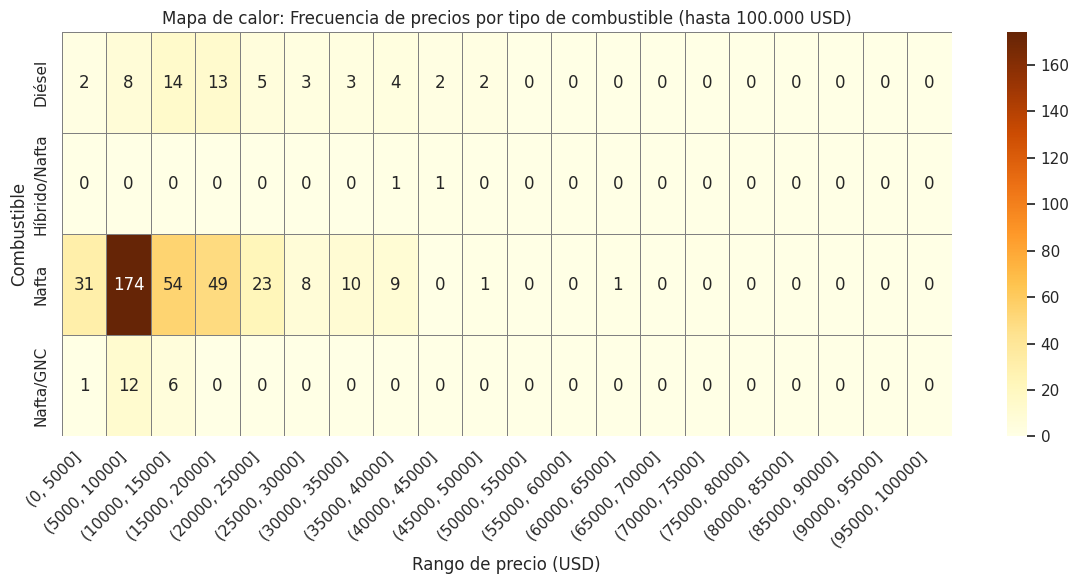

In [ ]:
# Agrupar los precios en bins definidos manualmente
price_bins = pd.interval_range(start=0, end=100000, freq=5000)
df_heat = df[df['Precio Dolarizado'] < 100000].copy()
df_heat['Precio Bin'] = pd.cut(df_heat['Precio Dolarizado'], bins=price_bins)
# Crear tabla de frecuencia cruzada entre tipo de combustible y rango de precio
heatmap_data = df_heat.pivot_table(index='combustible',columns='Precio Bin',aggfunc='size',fill_value=0)
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="YlOrBr", linewidths=0.5, linecolor='gray', annot=True, fmt="d")
plt.title("Mapa de calor: Frecuencia de precios por tipo de combustible (hasta 100.000 USD)")
plt.xlabel("Rango de precio (USD)")
plt.ylabel("Combustible")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Conclusión**
El mapa de calor muestra con claridad que la mayoría de los autos a la venta utilizan nafta como combustible y se concentran fuertemente en los rangos de precio entre 5.000 y 20.000 USD.

En segundo lugar, aunque en menor proporción, aparecen vehículos diésel, con una distribución algo más dispersa pero también centrada en precios bajos.
Los autos con GNC o tecnología híbrida representan una fracción muy pequeña del mercado.

Este patrón puede ser clave al momento de diseñar un modelo predictivo: el tipo de combustible podría tener una influencia significativa sobre el precio, aunque su poder explicativo variará según el segmento. También deja en evidencia un fuerte desbalance entre clases que podría ser relevante si se opta por clasificar o segmentar por tipo de combustible.


## 4.9 Distribución de precios por tipo de caja de cambios:
El tipo de transmisión (manual o automática) es una característica relevante que puede influir en el precio de un vehículo. Los autos con caja automática suelen estar asociados a modelos más nuevos o de mayor gama, mientras que la transmisión manual es más común en modelos económicos o utilitarios. Visualizar cómo varía el precio en función del tipo de caja puede ayudarnos a detectar diferencias clave entre segmentos y orientar decisiones en la construcción del modelo predictivo.

/tmp/ipython-input-15-3645203770.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df[df['Precio Dolarizado'] <= 100000],x='caja de cambio', y='Precio Dolarizado', palette=["#3990BE", "#42DBAD", "#E03FB9"], inner='quartile',linewidth=1)
/tmp/ipython-input-15-3645203770.py:2: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.violinplot(data=df[df['Precio Dolarizado'] <= 100000],x='caja de cambio', y='Precio Dolarizado', palette=["#3990BE", "#42DBAD", "#E03FB9"], inner='quartile',linewidth=1)


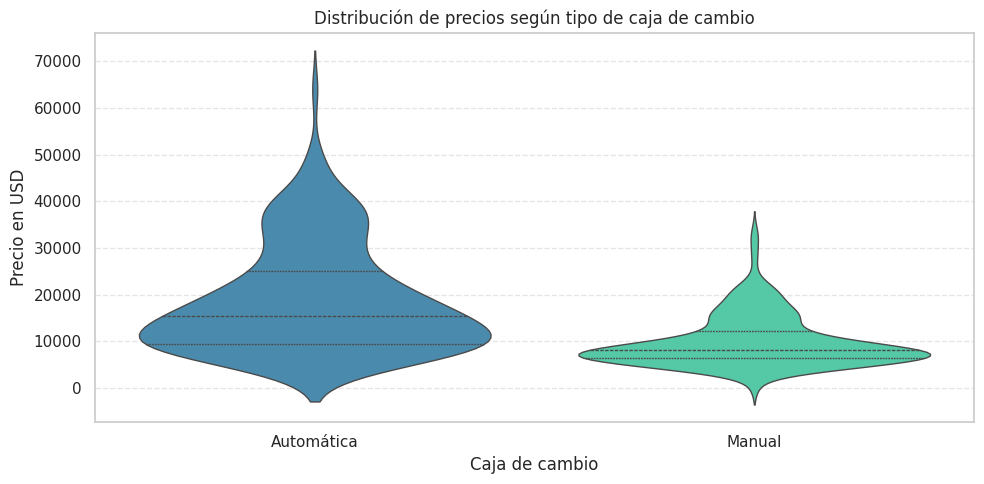

In [ ]:
plt.figure(figsize=(10,5))
sns.violinplot(data=df[df['Precio Dolarizado'] <= 100000],x='caja de cambio', y='Precio Dolarizado', palette=["#3990BE", "#42DBAD", "#E03FB9"], inner='quartile',linewidth=1)
plt.title("Distribución de precios según tipo de caja de cambio")
plt.xlabel("Caja de cambio")
plt.ylabel("Precio en USD")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Conclusión**

El gráfico revela que los autos con caja automática tienden a tener precios más altos en comparación con los de caja manual, lo cual es esperable ya que suelen corresponder a vehículos más modernos o de mayor confort.
También se observa una mayor variabilidad de precios en los automáticos, mientras que los autos manuales presentan una distribución más concentrada en el rango bajo.

## 4.10 Evolución del precio promedio por año (por marca)
Analizar el comportamiento del precio promedio por año, separado por marca, las marcas más tendenciosas en nuestra región, permite identificar cómo se ha valorizado o depreciado cada fabricante a lo largo del tiempo. Esta información puede resultar útil para interpretar tendencias del mercado o preparar un modelo de regresión más realista.

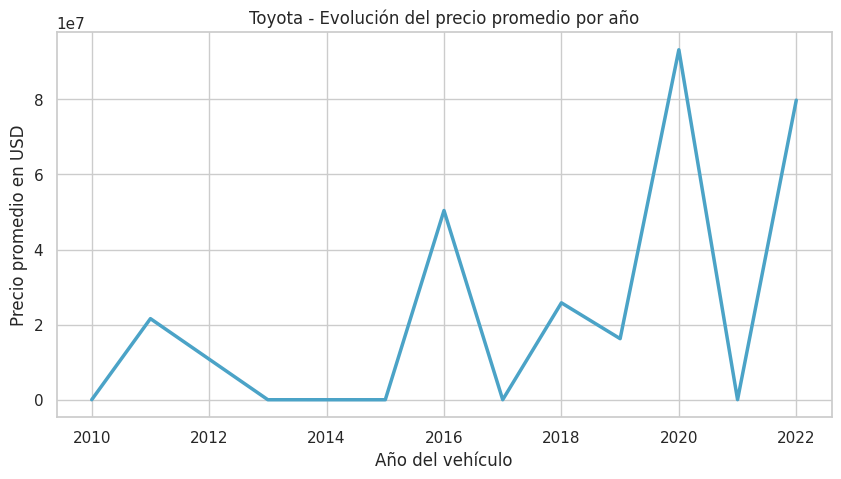

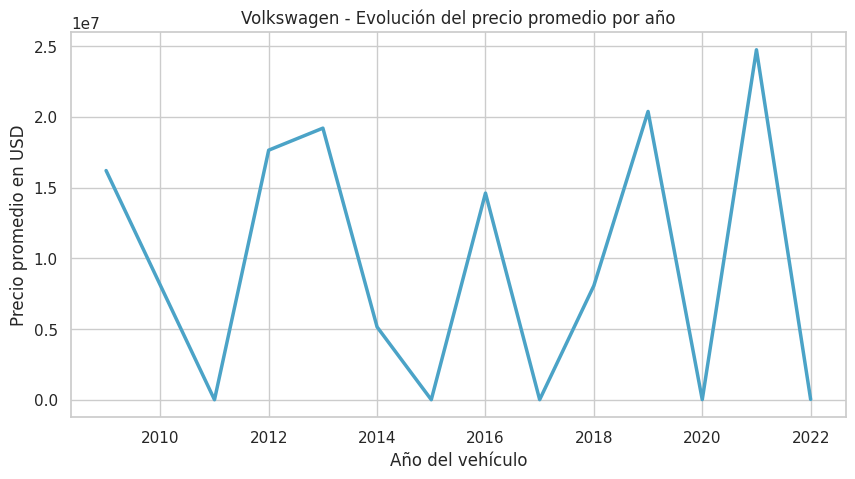

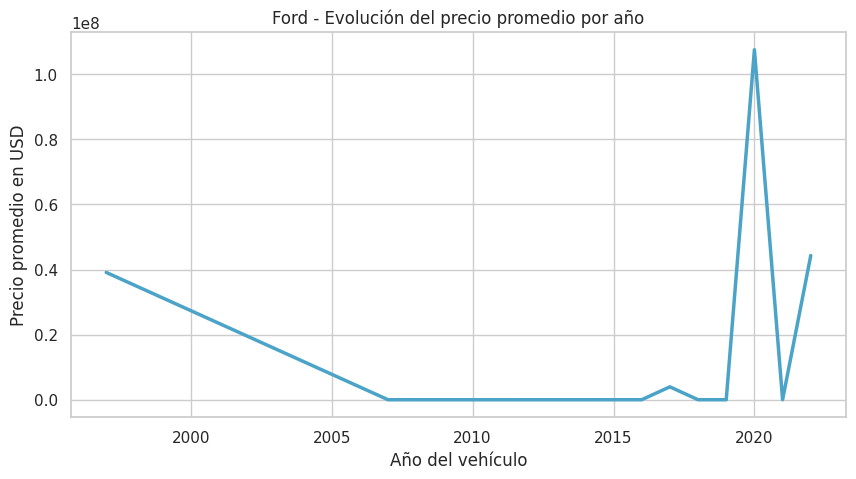

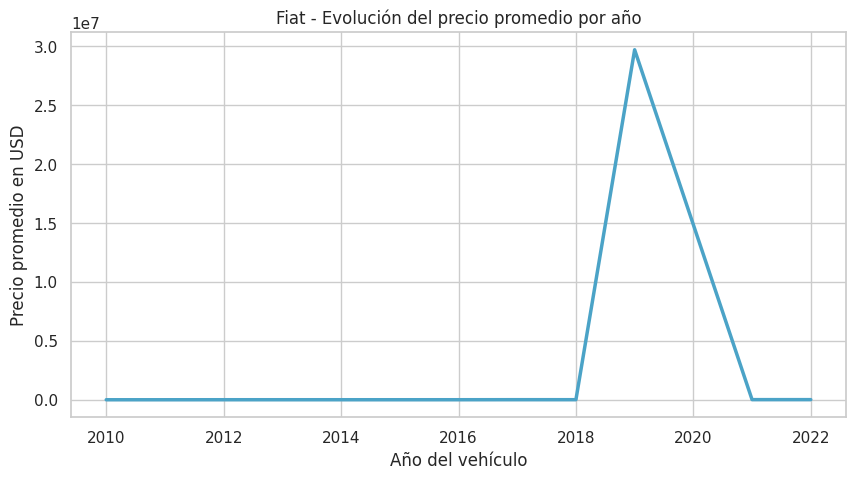

In [ ]:
# Toyota
df_toyota = df[df['marca'] == 'Toyota']
df_toyota_group = df_toyota.groupby('año')['Precio Dolarizado'].mean().reset_index()
plt.figure(figsize=(10,5))
sns.lineplot(data=df_toyota_group, x='año', y='Precio Dolarizado', color="#4BA3C7", linewidth=2.5)
plt.title("Toyota - Evolución del precio promedio por año")
plt.xlabel("Año del vehículo")
plt.ylabel("Precio promedio en USD")
plt.grid(True)
plt.show()
# Volkswagen
df_vw = df[df['marca'] == 'Volkswagen']
df_vw_group = df_vw.groupby('año')['Precio Dolarizado'].mean().reset_index()
plt.figure(figsize=(10,5))
sns.lineplot(data=df_vw_group, x='año', y='Precio Dolarizado', color="#4BA3C7", linewidth=2.5)
plt.title("Volkswagen - Evolución del precio promedio por año")
plt.xlabel("Año del vehículo")
plt.ylabel("Precio promedio en USD")
plt.grid(True)
plt.show()
# Ford
df_ford = df[df['marca'] == 'Ford']
df_ford_group = df_ford.groupby('año')['Precio Dolarizado'].mean().reset_index()
plt.figure(figsize=(10,5))
sns.lineplot(data=df_ford_group, x='año', y='Precio Dolarizado', color="#4BA3C7", linewidth=2.5)
plt.title("Ford - Evolución del precio promedio por año")
plt.xlabel("Año del vehículo")
plt.ylabel("Precio promedio en USD")
plt.grid(True)
plt.show()
# Fiat
df_fiat = df[df['marca'] == 'Fiat']
df_fiat_group = df_fiat.groupby('año')['Precio Dolarizado'].mean().reset_index()
plt.figure(figsize=(10,5))
sns.lineplot(data=df_fiat_group, x='año', y='Precio Dolarizado', color="#4BA3C7", linewidth=2.5)
plt.title("Fiat - Evolución del precio promedio por año")
plt.xlabel("Año del vehículo")
plt.ylabel("Precio promedio en USD")
plt.grid(True)
plt.show()

**Conclusión**
Las cuatro marcas analizadas muestran patrones de evolución distintos:

Toyota mantiene una tendencia de precios estables o en leve aumento en los últimos años, con valores promedio generalmente más altos.

Volkswagen presenta una curva más variable, pero con repuntes de precio en años recientes.

Ford muestra una caída en el precio promedio en algunos años, probablemente por modelos más antiguos o baja demanda.

Fiat, con precios generalmente más bajos, también mantiene cierta estabilidad, lo que podría estar relacionado con su segmento de mercado más económico.

Este tipo de análisis por marca es fundamental para capturar el comportamiento heterogéneo del mercado automotor argentino.

## 4.11 las 10 marcas con los autos más caros del dataset:
En base al precio máximo registrado para cada una. Es útil para observar qué marcas manejan valores extremos en el mercado de autos usados en Argentina, lo cual también puede revelar outliers o inconsistencias a tener en cuenta para el modelado posterior.

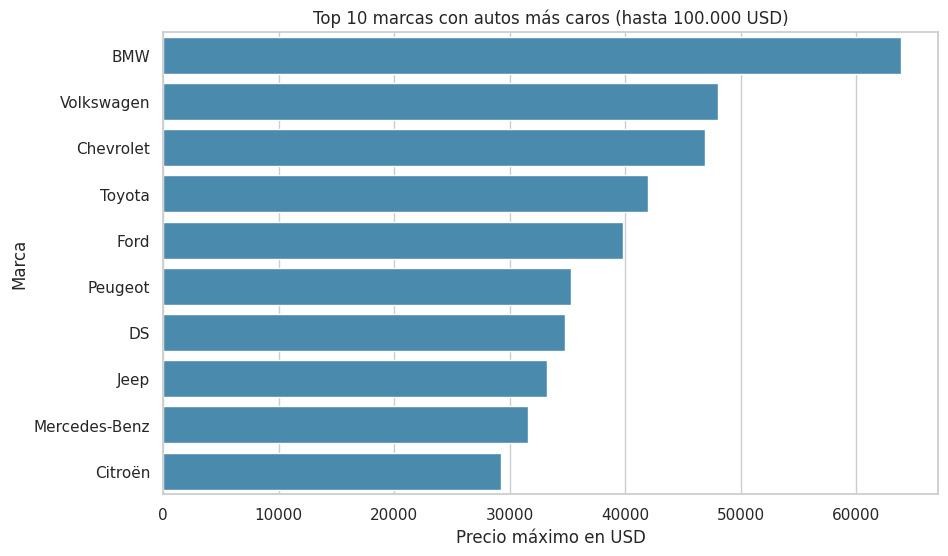

In [ ]:
# Filtramos solo autos con precios realistas (hasta 100.000 USD)
df_filtrado = df[df['Precio Dolarizado'] <= 100000]
# Calculamos el precio máximo por marca dentro de ese rango
top_precios_filtrados = df_filtrado.groupby('marca')['Precio Dolarizado'] \
                                   .max().sort_values(ascending=False).head(10)
# Gráfico
plt.figure(figsize=(10,6))
sns.barplot(x=top_precios_filtrados.values, y=top_precios_filtrados.index)
plt.title("Top 10 marcas con autos más caros (hasta 100.000 USD)")
plt.xlabel("Precio máximo en USD")
plt.ylabel("Marca")
plt.show()

**Conclusión**
Luego de eliminar precios fuera de rango (mayores a 100.000 USD), se observa que marcas como BMW, Audi, Mercedes-Benz y Ford continúan posicionándose entre las más costosas dentro del mercado argentino de autos usados.

Este gráfico refleja mejor la realidad comercial de vehículos de gama media y alta, sin la distorsión de outliers. Resulta más útil para el análisis predictivo, ya que evita valores que podrían generar sobreajustes en los modelos o conclusiones erróneas sobre la relación entre marca y precio.

## 4.12 Precio según Carrocería
El objetivo de este gráfico es visualizar cómo varía el precio promedio en dólares según el tipo de carrocería de los vehículos presentes en el dataset. Utilizando un mapa de calor en gama de azules, se logra representar de forma clara y comparativa qué tipos de carrocería concentran valores más altos o más bajos. Esta información resulta especialmente útil para entender tendencias de mercado y segmentación por estilo de vehículo.

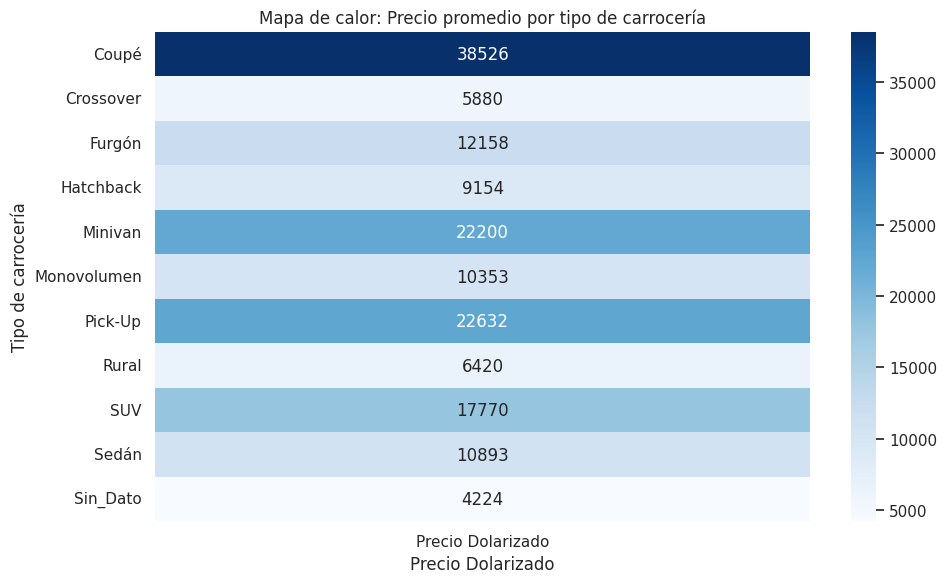

In [ ]:
df_heat = df.copy()
df_heat = df_heat[df_heat['Precio Dolarizado'] <= 100000]  # Filtro si lo estás usando
precio_promedio = df_heat.groupby('tipo de cuerpo')['Precio Dolarizado'].mean().reset_index()
# Pivot para heatmap
heatmap_data = precio_promedio.pivot_table(index='tipo de cuerpo', values='Precio Dolarizado')
# Gráfico
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="Blues", cbar=True)
plt.title("Mapa de calor: Precio promedio por tipo de carrocería")
plt.xlabel("Precio Dolarizado")
plt.ylabel("Tipo de carrocería")
plt.tight_layout()
plt.show()

**Conclusión**
Se observa que la carrocería Coupé presenta el precio promedio más alto, con 80.000 USD, lo que puede atribuirse a su orientación deportiva o de lujo. Por otro lado, las carrocerías Hatchback, Sedán y Minivan se encuentran entre las opciones más accesibles. Las Pick-Up y SUV también muestran precios elevados, lo cual es consistente con su tamaño, robustez y equipamiento.
El mapa de calor permite detectar estas diferencias de forma inmediata y evidencia cómo el diseño del vehículo impacta en su valor de mercado.

## 4.13 relación entre el tipo de motor de los vehículos y su precio promedio en dólares
Este gráfico busca analizar la relación entre el tipo de motor de los vehículos y su precio promedio en dólares. Agrupar esta información permite detectar cuáles son los tipos de motorización que tienden a tener un mayor valor en el mercado, lo que puede ser útil tanto para compradores como para desarrolladores de modelos predictivos.

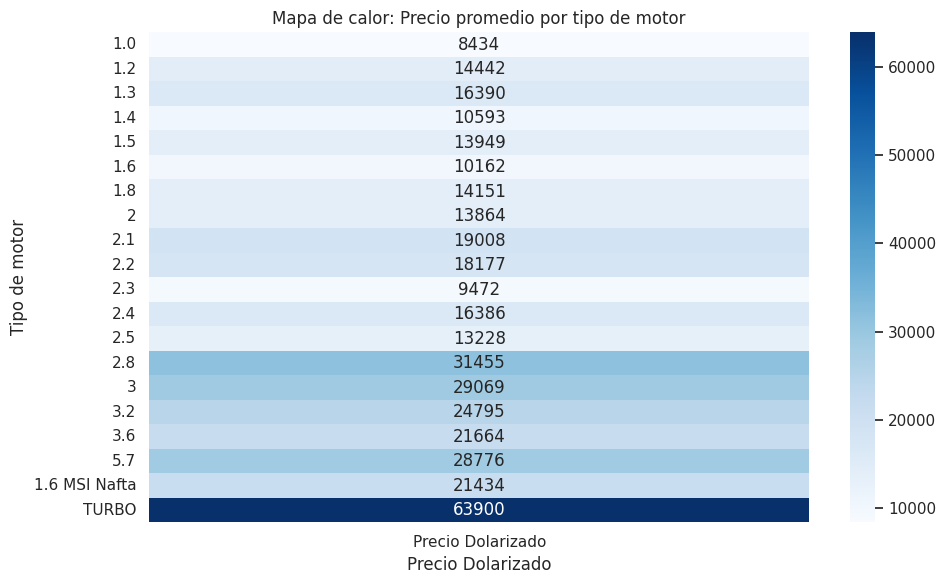

In [ ]:
# Copiamos y filtramos precios exagerados (opcional, pero recomendable)
df_heat = df.copy()
df_heat = df_heat[df_heat['Precio Dolarizado'] <= 100000]
# Quitamos los datos faltantes de 'motor'
df_heat = df_heat[df_heat['motor'] != 'Sin_Dato']
# Agrupamos por tipo de motor y calculamos el precio promedio
precio_prom_motor = df_heat.groupby('motor')['Precio Dolarizado'].mean().reset_index()
# Pivot para el heatmap
heatmap_data = precio_prom_motor.pivot_table(index='motor', values='Precio Dolarizado')
# Graficamos
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="Blues", cbar=True)
plt.title("Mapa de calor: Precio promedio por tipo de motor")
plt.xlabel("Precio Dolarizado")
plt.ylabel("Tipo de motor")
plt.tight_layout()
plt.show()

**Conclusión**
La visualización revela diferencias importantes en los precios promedio según el tipo de motor. Los motores más complejos o de mayor cilindrada tienden a estar asociados a vehículos de mayor valor, mientras que los motores más simples presentan precios más accesibles. Este patrón puede estar relacionado tanto con el rendimiento del vehículo como con su segmento de mercado (utilitario, deportivo, económico, etc.).

Además, este tipo de análisis permite detectar valores atípicos o inconsistencias en la carga de datos, y brinda un insumo clave para tareas de modelado y toma de decisiones.

## **4.14 Matriz de correlación extendida (numéricas + categóricas)**
Con el objetivo de analizar la relación entre el precio dolarizado y el resto de las variables del dataset, ampliamos el análisis de correlación incluyendo variables categóricas transformadas, como combustible, caja de cambio y tipo de carrocería. Esto nos permite tener una visión más completa de cómo se comportan entre sí las distintas características de los vehículos.

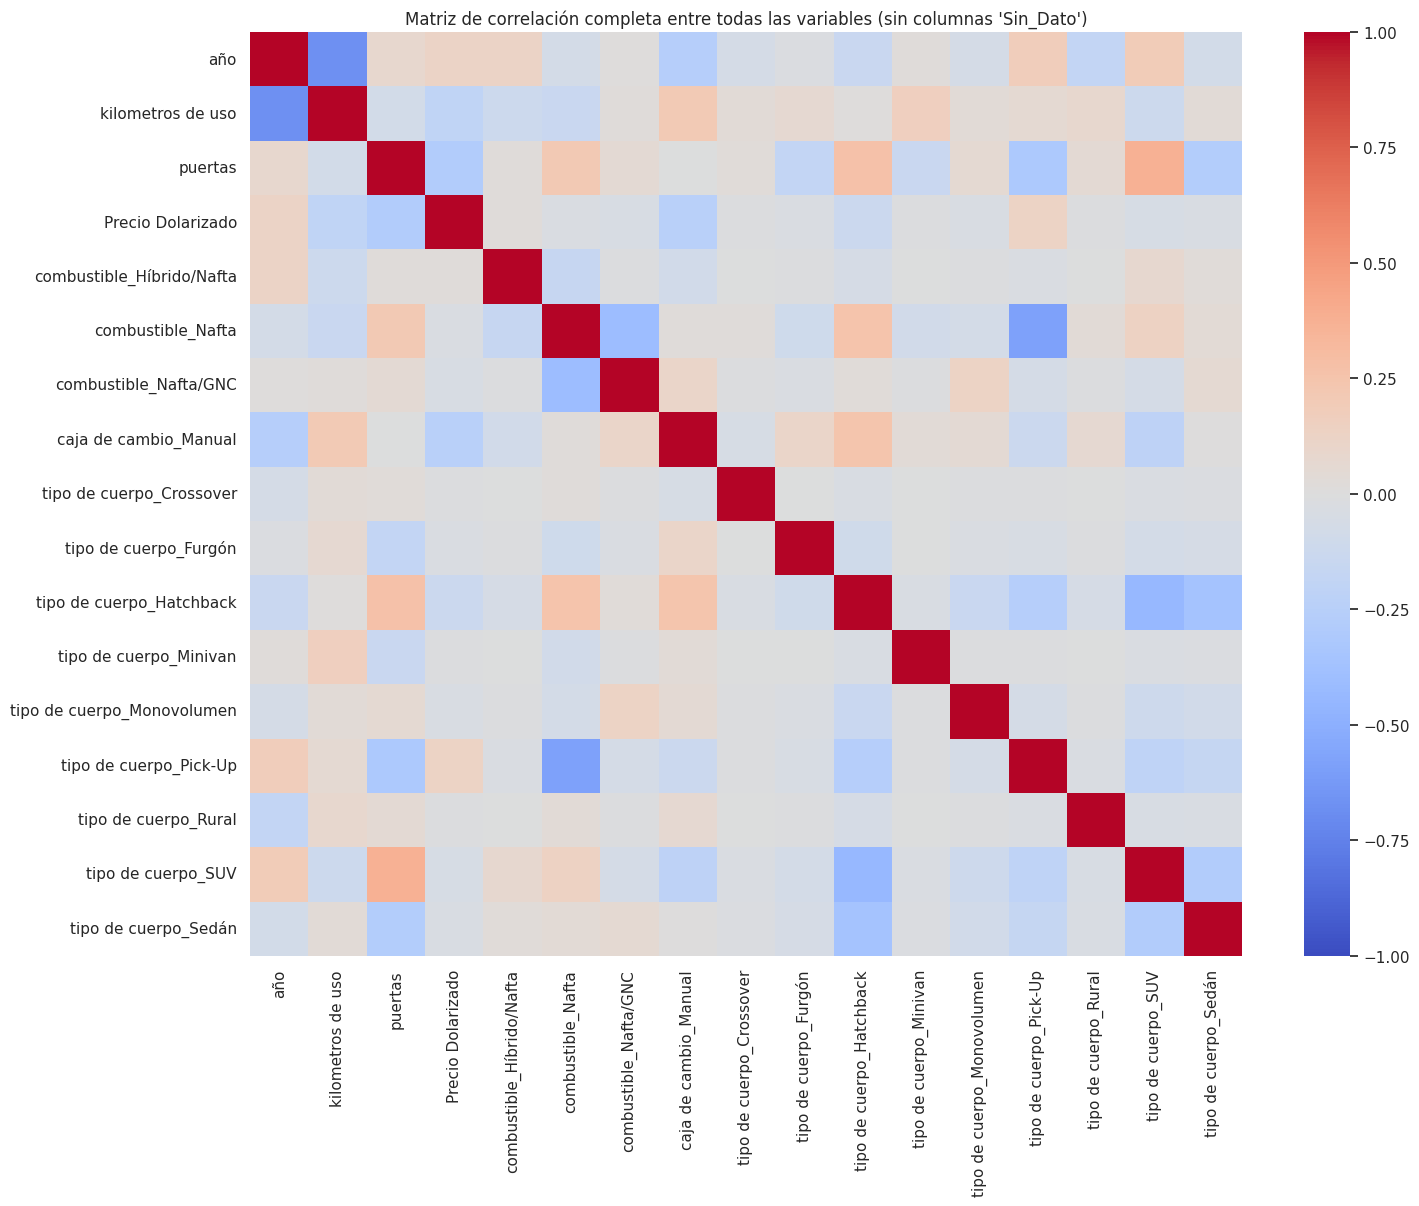

In [ ]:
# Creamos un nuevo DataFrame con variables numéricas y categóricas
df_corr = df[['año', 'kilometros de uso', 'puertas', 'Precio Dolarizado','combustible', 'caja de cambio', 'tipo de cuerpo']].copy()
# Convertimos las variables categóricas en variables dummies (sin incluir la categoría base)
df_dummies = pd.get_dummies(df_corr[['combustible', 'caja de cambio', 'tipo de cuerpo']], drop_first=True)
# Eliminamos las columnas que contienen "Sin_Dato"
df_dummies = df_dummies.loc[:, ~df_dummies.columns.str.contains("Sin_Dato")]
# Unimos el DataFrame original con los dummies
df_corr = pd.concat([df_corr.drop(columns=['combustible', 'caja de cambio', 'tipo de cuerpo']), df_dummies], axis=1)
# Graficamos la matriz de correlación completa
plt.figure(figsize=(16,12))
sns.heatmap(df_corr.corr(), cmap='coolwarm', annot=False, fmt=".2f", vmin=-1, vmax=1)
plt.title("Matriz de correlación completa entre todas las variables (sin columnas 'Sin_Dato')")
plt.show()

**Conclusión**

La matriz de correlación completa muestra que las variables numéricas y dummies incluidas en el análisis tienen, en general, baja correlación con el precio.
Las correlaciones más destacadas son:

>**Kilómetros de uso**: presenta una correlación negativa moderada con el precio (~ -0.20), indicando que a mayor uso, menor valor de mercado.

>**Año**: muestra una correlación levemente positiva (~ 0.12), lo que sugiere que los modelos más nuevos tienden a ser más caros.

*El resto de las variables*, incluyendo puertas, combustible, tipo de cuerpo y caja de cambio, tienen correlaciones muy bajas, por lo que su influencia directa sobre el precio parece limitada.

Este tipo de análisis nos ayuda a priorizar variables relevantes para futuros modelos predictivos y a detectar relaciones poco significativas o redundantes.

## **4.15 precio promedio dolarizado de vehículos**
En este análisis comparamos el precio promedio dolarizado de vehículos filtrando por dos aspectos claves:

Marca (limitándonos a las 4 más relevantes del dataset: Toyota, Volkswagen, Fiat y Ford).

Estado del vehículo, clasificado como Nuevo si tiene menos de 1.000 km, o Usado en caso contrario.

Para evitar sesgos por valores extremos (outliers), se aplicó un filtro adicional a los datos, conservando únicamente los vehículos con precios inferiores a 100.000 USD, buscando representar el mercado real de forma más fiel.

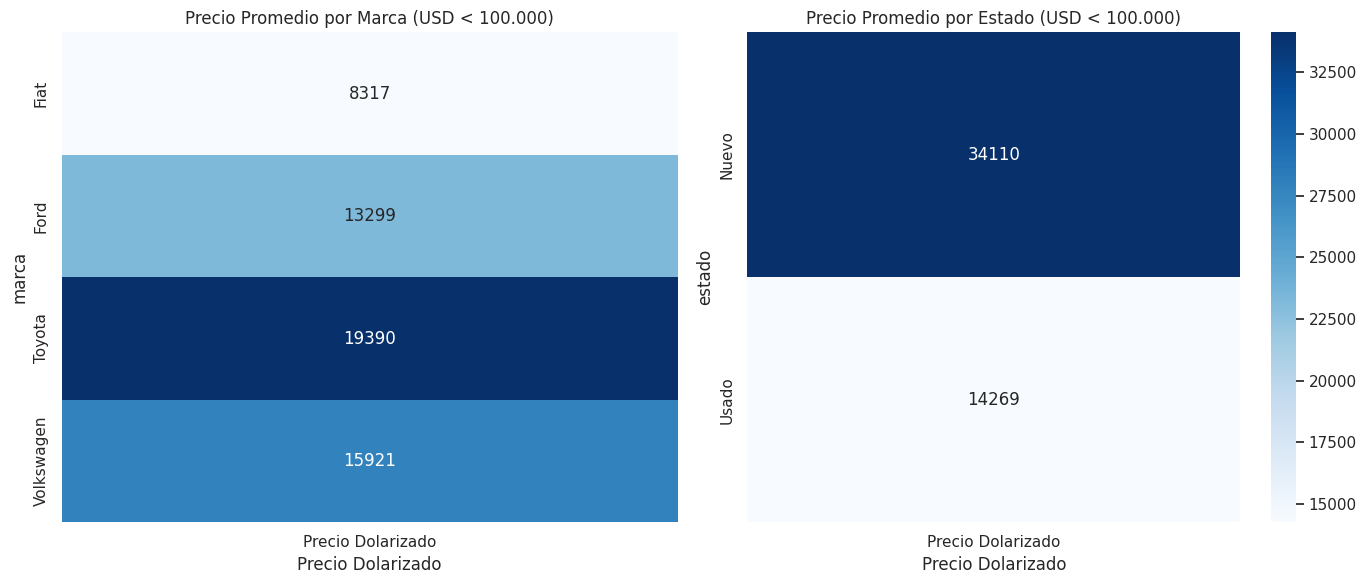

In [ ]:
# Paso 1: Filtro de marcas, precio y creación de variable estado
marcas_interes = ['Toyota', 'Volkswagen', 'Ford', 'Fiat']
df_filtrado = df[(df['marca'].isin(marcas_interes)) & (df['Precio Dolarizado'] < 100000)].copy()
df_filtrado['estado'] = df_filtrado['kilometros de uso'].apply(lambda x: 'Nuevo' if x <= 1000 else 'Usado')
# Paso 2: Agrupaciones
marca_pivot = df_filtrado.groupby('marca')['Precio Dolarizado'].mean().reset_index().pivot_table(index='marca', values='Precio Dolarizado')
estado_pivot = df_filtrado.groupby('estado')['Precio Dolarizado'].mean().reset_index().pivot_table(index='estado', values='Precio Dolarizado')
# Paso 3: Mapas de calor
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(marca_pivot, cmap="Blues", annot=True, fmt=".0f", ax=axes[0], cbar=False)
axes[0].set_title("Precio Promedio por Marca (USD < 100.000)")
axes[0].set_xlabel("Precio Dolarizado")
sns.heatmap(estado_pivot, cmap="Blues", annot=True, fmt=".0f", ax=axes[1])
axes[1].set_title("Precio Promedio por Estado (USD < 100.000)")
axes[1].set_xlabel("Precio Dolarizado")
plt.tight_layout()
plt.show()

**Conclusión**

Los gráficos muestran con claridad que:

Toyota tiene el precio promedio más alto entre las marcas analizadas, seguido de cerca por Volkswagen y Ford. Fiat, en cambio, se posiciona como la más económica en promedio.

Al comparar por estado del vehículo, se observa una diferencia significativa:
los autos nuevos tienen un precio promedio de alrededor de 34.000 USD, mientras que los usados promedian 14.000 USD, lo cual es coherente con la depreciación natural por uso.

Este análisis permite entender la influencia de la marca y del estado sobre el valor de mercado de los autos en Argentina y será útil para futuras tareas de modelado o predicción.

#**5. Modelos de regresión:**

En esta sección se implementa un modelo de regresión lineal simple con el objetivo de predecir el precio dolarizado de los vehículos.
Para ello, seleccionamos tres variables numéricas con buena relevancia según el análisis previo:

>**año**

>**kilómetros de uso**

> **tipo de cuerpo_SUV**

El procedimiento consiste en:

Dividir el conjunto de datos en entrenamiento (80%) y prueba (20%)

Entrenar el modelo con los datos conocidos

Evaluar el rendimiento del modelo con métricas estándar de regresión:

MAE (Error Absoluto Medio)

MSE (Error Cuadrático Medio)

R² (Coeficiente de Determinación)



📊 Resultados del modelo (precios en dólares, sin log, sin Pick-Up):
MAE: 2988.7999057462903
MSE: 19750791.120326523
R²: 0.7071088771484461


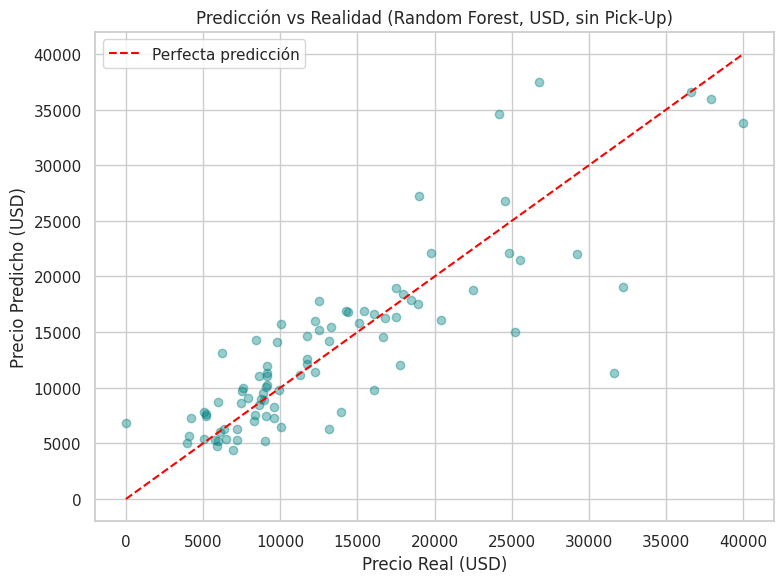

In [39]:
columnas_categoricas = ['tipo de cuerpo', 'combustible', 'caja de cambio']
df_dummies = pd.get_dummies(df, columns=columnas_categoricas, drop_first=True)

# Filtramos autos con precios extremos (mayores a 40 mil dólares)
df_dummies = df_dummies[df_dummies['Precio Dolarizado'] < 40_000]

#Definimos las variables seleccionadas (excluyendo tipo de cuerpo_Pick-Up)
columnas_modelo = [
    'año',
    'tipo de cuerpo_SUV',
    'tipo de cuerpo_Sedán',
    'tipo de cuerpo_Hatchback',
    'tipo de cuerpo_Crossover',
    'kilometros de uso',
    'combustible_Híbrido/Nafta',
    'caja de cambio_Manual'
]

#Verificamos que existan en el DataFrame
columnas_existentes = [col for col in columnas_modelo if col in df_dummies.columns]
X = df_dummies[columnas_existentes]
y = df_dummies['Precio Dolarizado']  # Ahora sí usamos directamente el precio en dólares

#División en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Entrenamos el modelo
modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42)
modelo_rf.fit(X_train, y_train)

#Predicciones
y_pred = modelo_rf.predict(X_test)

#Métricas
print("\n📊 Resultados del modelo (precios en dólares, sin log, sin Pick-Up):")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

#Gráfico de dispersión
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.4, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfecta predicción")
plt.xlabel('Precio Real (USD)')
plt.ylabel('Precio Predicho (USD)')
plt.title('Predicción vs Realidad (Random Forest, USD, sin Pick-Up)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Conclusión**

El gráfico de dispersión entre el precio real y el precio predicho muestra un desempeño razonablemente bueno en el rango de 5.000 a 20.000 USD, donde se concentra la mayor parte de los autos del dataset. Dentro de ese segmento, el modelo logra realizar predicciones cercanas al valor real, con un margen de error promedio de aproximadamente 3.000 USD.

Sin embargo, a medida que se incrementa el valor del vehículo (especialmente entre los 30.000 y 40.000 USD), se observa una mayor dispersión en las predicciones. Esto indica que el modelo no cuenta con suficiente representación de autos premium para distinguir correctamente sus características, lo cual reduce su capacidad predictiva en ese rango. A pesar de ello, no se evidencian errores catastróficos; el modelo no predice valores completamente alejados de la realidad, lo que demuestra cierta solidez estructural.

A partir de esta experiencia, se identifican varias herramientas teóricas aprendidas en el curso que podrían implementarse para mejorar los resultados:

- **Segmentación por rangos de precio:** entrenar modelos separados para vehículos económicos y de alta gama.
- **Ingeniería de características:** derivar nuevas variables como los años del auto, la relación entre uso y año, o variables compuestas que reflejen atributos técnicos.
- **Análisis de outliers y revisión semántica:** explorar marcas o modelos mal categorizados o con muy poca representación.
- **Balanceo del conjunto de datos:** incorporar más observaciones representativas de vehículos caros o poco frecuentes.

En síntesis, este modelo permitió comprobar que, aún con un conjunto de variables relativamente simple, se puede obtener una capacidad predictiva aceptable. Además, demostró que los resultados pueden mejorar sustancialmente al tratar con datos consistentes, representativos y adecuadamente preprocesados. Esta versión final ofrece un punto de partida sólido para futuras iteraciones y pruebas más avanzadas.


#**6. Conclusión final**
A lo largo del desarrollo de este trabajo final, se recorrieron todas las etapas fundamentales de machine learning aplicado a un problema de regresión con datos reales del mercado automotor argentino. Se partió de un análisis exploratorio sencillo, donde se evaluó la distribución de las variables, su correlación con el precio dolarizado, y se identificaron aquellas que podían tener valor predictivo.

Sse aplicó un modelo de Random Forest, primero con transformaciones logarítmicas del precio que terminaron afectando negativamente la performance, y luego con el precio directamente en dólares, lo cual resultó ser una decisión más acertada. La versión final del modelo, sin transformación logarítmica y usando solo las 8 variables más correlacionadas, logró un desempeño considerablemente superior, con un R² ≈ 0.71 y un MAE de alrededor de 3.000 USD.

Este resultado demuestra no solo que el modelo puede ser útil para estimar precios en rangos razonables, sino que el aprendizaje obtenido sobre la calidad de los datos, el tratamiento de variables categóricas, la segmentación, y la correcta selección de métricas, es tan valioso como el ajuste en sí. El análisis también permitió identificar limitaciones estructurales, como el desbalance en la representación de autos de alta gama, y abrió la puerta a futuras mejoras como la segmentación de modelos, la ingeniería de nuevas variables, y la recolección dirigida de datos.

Se aplicaron técnicas de reducción de variables, se entrenó y evaluó un modelo de regresión, se interpretaron métricas clave y se extrajeron conclusiones basadas en evidencia.